# ISPR Midterm 1 - Assignment 4

### Diego Arcelli - 647979

#### Image segmentation using the Normalized Cut algorithm

## Downloading the dataset

In [ ]:
!wget https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip 
!unzip msrc_objcategimagedatabase_v1.zip 
!rm msrc_objcategimagedatabase_v1.zip 

--2023-03-18 14:09:36--  https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.91.72.223, 2600:1417:e800:18d::317f, 2600:1417:e800:187::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.91.72.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M  23.9MB/s    in 1.8s    

2023-03-18 14:09:39 (23.9 MB/s) - ‘msrc_objcategimagedatabase_v1.zip’ saved [44119839/44119839]

Archive:  msrc_objcategimagedatabase_v1.zip
  inflating: MSRC_ObjCategImageDatabase_v1/1_10_s.bmp  
  inflating: MSRC_ObjCategImageDatabase_v1/1_10_s_GT.bmp  
  inflating: MSRC_ObjCategImageDatabase_v1/1_11_s.bmp  
  inflating: MSRC_ObjCategImageDatabase_v1/1_11_s_GT.bmp  
  inflating: MSRC_ObjCategImageDatabase

## Importing needed modules

In [ ]:
import skimage
from skimage.segmentation import mark_boundaries, slic
import skimage
import matplotlib.pyplot as plt
from skimage.future import graph
from skimage.color import rgb2gray
from skimage.filters import sobel
import os
from sklearn.metrics import jaccard_score
import numpy as np
from tqdm import tqdm
import pandas as pd
!pip install networkx==2.8.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Defining color-label assocations

In [ ]:
# dictionary that maps labels to an RGB color
class_to_color = dict()
class_to_color["void"] = (0, 0, 0)
class_to_color["building"] = (128, 0, 0)
class_to_color["grass"] = (0, 128, 0)
class_to_color["tree"] = (128, 128, 0)
class_to_color["cow"] = (0, 0, 128)
class_to_color["horse"] = (128, 0, 128)
class_to_color["sheep"] = (0, 128, 128)
class_to_color["sky"] = (128, 128, 128)
class_to_color["mountain"] = (64, 0, 0)
class_to_color["aeroplane"] = (192, 0, 0)
class_to_color["water"] = (64, 128, 0)
class_to_color["face"] = (192, 128, 0)
class_to_color["car"] = (64, 0, 128)
class_to_color["bicycle"] = (192, 0, 128)

# dictionary that maps an RGB color to a label
color_to_class = dict()
for class_name, color in class_to_color.items():
    color_to_class[color] = class_name

## Defining utility functions
All the function used to generate the superpixels, apply the NCut algorithm and evaluate the result of the segmentation

In [ ]:
'''
Function that returns two list:
- images: the list of the file names of all the images to segment
- targets: the list of the file names of all the ground-truth images
'''
def read_images(path="MSRC_ObjCategImageDatabase_v1"):
    data = os.listdir(path)
    targets = list(filter(lambda x: x[-6:] == "GT.bmp", data))
    images = list(filter(lambda x: x[-6:] != "GT.bmp" and x[-4:] == ".bmp", data))
    images = sorted(images)
    targets = sorted(targets)
    return images, targets

'''
funciton that produces the segmentation of the input image
'''
def get_semantic_segmentation(img, n_segments=400, compactness=30, sigma=1):
    # get the super pixels of the images
    super_pixels = slic(img, n_segments=n_segments, compactness=compactness, sigma=sigma, start_label=1)
    
    marked_super_pixels = mark_boundaries(img, super_pixels)
    super_pixels_img = skimage.color.label2rgb(super_pixels, img, kind='avg', bg_label=0)
    g = graph.rag_mean_color(img, super_pixels, mode='similarity')
    labels = graph.cut_normalized(super_pixels, g)
    img_segmented = skimage.color.label2rgb(labels, img, kind='avg')
    return img_segmented, super_pixels_img, marked_super_pixels


'''
function to update the image produced by the NCut algorithm
by assigning to each segment the color of the associated label
'''
def update_image(img, colors_update):
    
    h, w, c = img.shape
    new_img = np.zeros(shape=(h, w, c))

    for i in range(h):
        for j in range(w):
            old_color = img[i, j, :]
            new_color = colors_update[tuple(old_color)]
            new_img[i, j, :] = new_color

    return new_img.astype(np.int32)


'''
function to measure the overlapping of two segments using the jaccard similarity
'''
def intersection_over_union(img_pos, trg_pos):
    img_pos = set(img_pos)
    trg_pos = set(trg_pos)
    inter = img_pos.intersection(trg_pos)
    union = img_pos.union(trg_pos)
    return len(inter)/len(union)


'''
function that compare one segment prodcued by NCut with all the segments
of the ground truth image, in order to measure which is the segment
of the ground truth with which the NCut's segment has more overlapping 
'''
def get_segment_class(color_pos, trg_color_to_pos, trg):
    
    sim_max = float("-inf")
    new_color = None

    for seg_color, seg_pos  in trg_color_to_pos.items():
        sim = intersection_over_union(color_pos, seg_pos)
        if sim > sim_max:
            new_color = seg_color
            sim_max = sim

    return new_color


'''
function that retuns a set of all the colors in the input image
'''
def extract_segments(img):
    h, w, c = img.shape
    flat_img = img.reshape(h*w, c)
    colors = set(list(map(lambda x: tuple(x), flat_img)))
    return colors

'''
function that extract all the colors of the input image and then
returns a tuple of the label assigned to the extracted colors
'''
def extract_classes(img):
    colors = extract_segments(img)
    classes = tuple(map(lambda x: color_to_class[x], colors))
    return classes


'''
function that return the list of all the pixels of the color passed as parameter
'''
def get_pixels_pos(colors, img):

    color_to_pos = dict()
    for color in colors:
        color_to_pos[color] = []

    h, w, _ = img.shape
    for i in range(h):
        for j in range(w):
            img_color = tuple(img[i, j, :])
            for color in colors:
                if color == img_color:
                    color_to_pos[color].append((i, j))

    return color_to_pos
            
             

'''
function that assigns to each segmented produced by NCut a
label by comparing the produced image with the ground truth 
'''
def assign_labels(img, trg):

    colors_update = dict()

    img_colors = extract_segments(img)
    trg_colors = extract_segments(trg)
    
    img_color_to_pos = get_pixels_pos(img_colors, img)
    trg_color_to_pos = get_pixels_pos(trg_colors, trg)

    for color in img_colors:
        new_color = get_segment_class(img_color_to_pos[color], trg_color_to_pos, trg)
        colors_update[color] = new_color

    new_img = update_image(img, colors_update)

    return new_img


'''
function to measure the similarity between the ground truth and
the result produced by the NCut using the pixel accuracy 
'''
def pixel_accuracy(img, trg):
    h, w, _ = img.shape
    comp = (img == trg)
    comp = comp.reshape(h*w, 3)
    accs = list(map(lambda elm: elm[0] and elm[1] and elm[2], comp))
    return sum(accs)/len(accs)


'''
function to measure the similarity between the ground truth and
the result produced by the NCut using the jaccard similarity 
'''
def jaccard_similarity(img, trg):
    h, w, _ = img.shape

    img = img.reshape(h*w, 3)
    trg = trg.reshape(h*w, 3)

    img = list(map(lambda x: color_to_class[tuple(x)], img))
    trg = list(map(lambda x: color_to_class[tuple(x)], trg))

    labels = list(set(trg))

    return jaccard_score(trg, img, labels=labels, average='weighted')

'''
function that applies the image segmentation of the input image and shows all the intermediate results
'''
def plot_segmented_images(img, trg, n_segments=800, compactness=30, sigma=1):
    out, out_marked, marked = get_semantic_segmentation(img, n_segments=n_segments, compactness=compactness, sigma=sigma)
    new_img = assign_labels(out, trg)

    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    ax[0, 0].imshow(img)
    ax[0, 0].set_title("Original image")
    ax[0, 0].set_xticks([])
    ax[0, 0].set_yticks([])

    ax[0, 1].imshow(out_marked)
    ax[0, 1].set_title("Superpixels")
    ax[0, 1].set_xticks([])
    ax[0, 1].set_yticks([])

    ax[0, 2].imshow(marked)
    ax[0, 2].set_title("Marked superpixels")
    ax[0, 2].set_xticks([])
    ax[0, 2].set_yticks([])

    ax[1, 0].imshow(out)
    ax[1, 0].set_title("Segmented image")
    ax[1, 0].set_xticks([])
    ax[1, 0].set_yticks([])

    ax[1, 1].imshow(new_img)
    ax[1, 1].set_title("Labeled image")
    ax[1, 1].set_xticks([])
    ax[1, 1].set_yticks([])

    ax[1, 2].imshow(trg)
    ax[1, 2].set_title("Ground truth")
    ax[1, 2].set_xticks([])
    ax[1, 2].set_yticks([])
        
    plt.show()


'''
function that computes the image segmentation of the input image and measure the
pixel accuracy and the jaccard similarity with respect to the ground truth 
'''
def evaluate_semantic_segmentation(img_path, trg_path, n_segments=800, compactness=30, sigma=1):
    img = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/" + img_path)
    trg = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/" + trg_path)

    img_seg, _, _ = get_semantic_segmentation(img, n_segments=n_segments, compactness=compactness, sigma=sigma)
    img_labeled = assign_labels(img_seg, trg)
    

    pixel_acc = pixel_accuracy(img_labeled, trg)
    jaccard_sim = jaccard_similarity(img_labeled, trg)

    return pixel_acc, jaccard_sim

## Process explanation
In this section of the notebook I explain the process used to perform and evaluate the images segmentation

## Loading the image to segment and the ground-truth

We load the image to segment and the ground truth

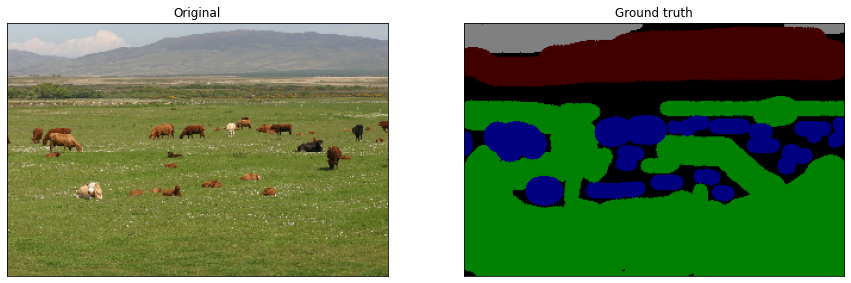

In [ ]:
images_path, targets_path = read_images()

fig, ax = plt.subplots(1, 2, figsize=(15, 15))

img = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/" +  images_path[0])

trg = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/" +  targets_path[0])

ax[0].imshow(img)
ax[0].set_title("Original")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(trg)
ax[1].set_title("Ground truth")
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

## Apply segmentation

We apply the segmentation of the input image. In order to do this first we produce the superpixels using the SLIC algorithm, then we apply NCut on the superpixelled image.

The SLIC algorithm has 3 parameters:
- `n_segments`: the number of superpixels
- `compactness`: basically it regulars the shape of the superpixels, high values make the superpixels more squared, while low values make the superpixels more irregular in the shape
- `sigma`: parameters of the Gaussian filter that is applied to the image before extracting the superpixels

I played a bit with the parameters of the algorithm in order to find a tradeoff between the number of superpixels and the time complexity. In the end I used `n_segments=400`, `compactness=30` and `sigma=1`.

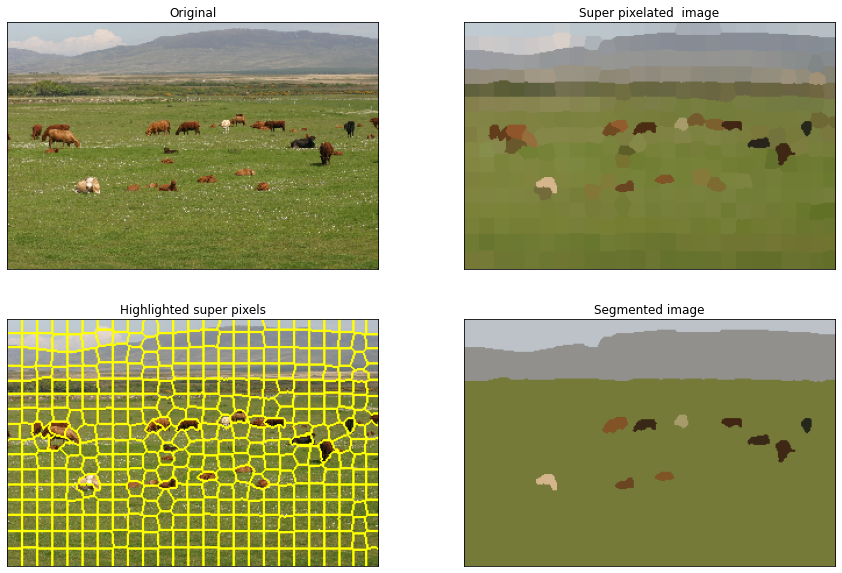

In [ ]:
img_segmented, super_pixels_img, marked_super_pixels = get_semantic_segmentation(img, 400, 30, 1)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].imshow(img)
ax[0, 0].set_title("Original")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(super_pixels_img)
ax[0, 1].set_title("Super pixelated  image")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])


ax[1, 0].imshow(marked_super_pixels)
ax[1, 0].set_title("Highlighted super pixels")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(img_segmented)
ax[1, 1].set_title("Segmented image")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

plt.show()

## Label assignment
NCut produces the segmentation but doesn't classify the segment. So I produce artificially a labeling of the segments returned by the NCut in the following way: for each segment produced by NCut we compute the overlapping between that segment and each segment of the ground truth image. Then we assign to the NCut segment the label of the ground-truth  segment with which it has the greatest overlap.

The overlapping is computed using the Jaccard similarity:

$ S(A, B) = \frac{|A \cap B|}{|A \cup B|} $

where $A$ is the set of pixels of the first segment and $B$ is the set of pixels of the second segment.

After having assigned every segment to a label, we re-color the pixels of the segment using the label-color mapping provided with the dataset.

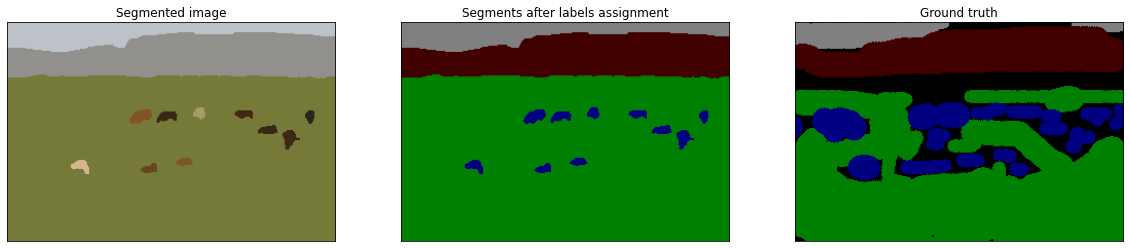

In [ ]:
img_labeled = assign_labels(img_segmented, trg)

fig, ax = plt.subplots(1, 3, figsize=(20, 15))

ax[0].imshow(img_segmented)
ax[0].set_title("Segmented image")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(img_labeled)
ax[1].set_title("Segments after labels assignment")
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(trg)
ax[2].set_title("Ground truth")
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

## Evaluation
For the evaluation of the segmented image I used the following metrics:
- Pixel accuracy
- Jaccard similarity

In [ ]:
pixel_acc = pixel_accuracy(img_labeled, trg)
jaccard_sim = jaccard_similarity(img_labeled, trg)

print(f"Pixel accuracy: {pixel_acc}")
print(f"Jaccard similarity: {jaccard_sim}")

Pixel accuracy: 0.7198650234741784
Jaccard similarity: 0.5300278207111415


## Summary of the whole process

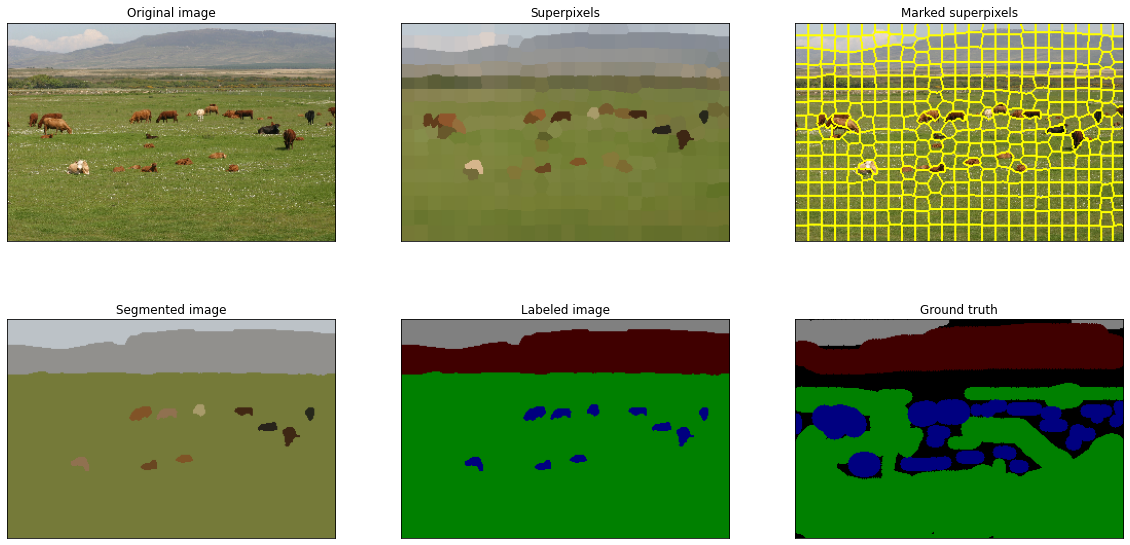

In [ ]:
plot_segmented_images(img, trg, 400, 30, 1)

## Evaluating NCut on all the images
We apply the NCut to all the images of the dataset and we evaluate the result separately for each class of images, by measuring the average pixel accuracy and the average Jaccard similarity on the images of each class.

In [ ]:
image_clases = [str(x) for x in range(1,9)]

datasets = dict()
for img_class in image_clases:

    class_images = list(filter(lambda x: x[0] == img_class, images_path))
    class_targets = list(filter(lambda x: x[0] == img_class, targets_path))
    datasets[img_class] = {
        "src": None,
        "trg": None
    }

    datasets[img_class]["src"] = class_images
    datasets[img_class]["trg"] = class_targets

In [ ]:
results = dict()
results["image_class"] = []
results["image_name"] = []
results["pixel_acc"] = []
results["jaccard_sim"] = []

for img_class in image_clases:
    images = datasets[img_class]["src"]
    targets = datasets[img_class]["trg"]
    
    img_class_pixel_acc = []
    img_class_jaccard_sim = []

    with tqdm(total=len(images)) as pbar:
        for img, trg in zip(images, targets):

            results["image_class"].append(img_class)
            results["image_name"].append(img)

            pixel_acc, jaccard_sim = evaluate_semantic_segmentation(img, trg, n_segments=400, compactness=30, sigma=1)
            img_class_pixel_acc.append(pixel_acc)
            img_class_jaccard_sim.append(jaccard_sim)

            results["pixel_acc"].append(pixel_acc)
            results["jaccard_sim"].append(jaccard_sim)
            
            pbar.update(1)
    

100%|██████████| 30/30 [07:56<00:00, 15.87s/it]


In [ ]:
results_df = pd.DataFrame(results)

## Printing the average pixel accuracy and the average Jaccard similarity for each class of images


In [ ]:
results_df[["image_class", "pixel_acc", "jaccard_sim"]].groupby("image_class", as_index=False).mean()

,image_class,pixel_acc,jaccard_sim
0,1,0.838274,0.732104
1,2,0.818265,0.704450
2,3,0.786120,0.663788
3,4,0.821762,0.701609
4,5,0.820876,0.714034
5,6,0.890720,0.812456
6,7,0.819828,0.710281
7,8,0.730235,0.577610


## Comments on the results

The class of images that gets the best average score for both metrics is the class 6, that contains images where the only two segments are the face of a person and the background. Faces have a compact and ciruclar shape, so they easy to segment.

The class of images that gets the worst average score for both metrics is the class 8, that contains images of bikes. Probably the irregular complex shape of the bike makes it harder for the algorithm to produce a good segmentation. In the below example we can see that the algorithm mixes the bikes with the background.

### Example of an image of class 6

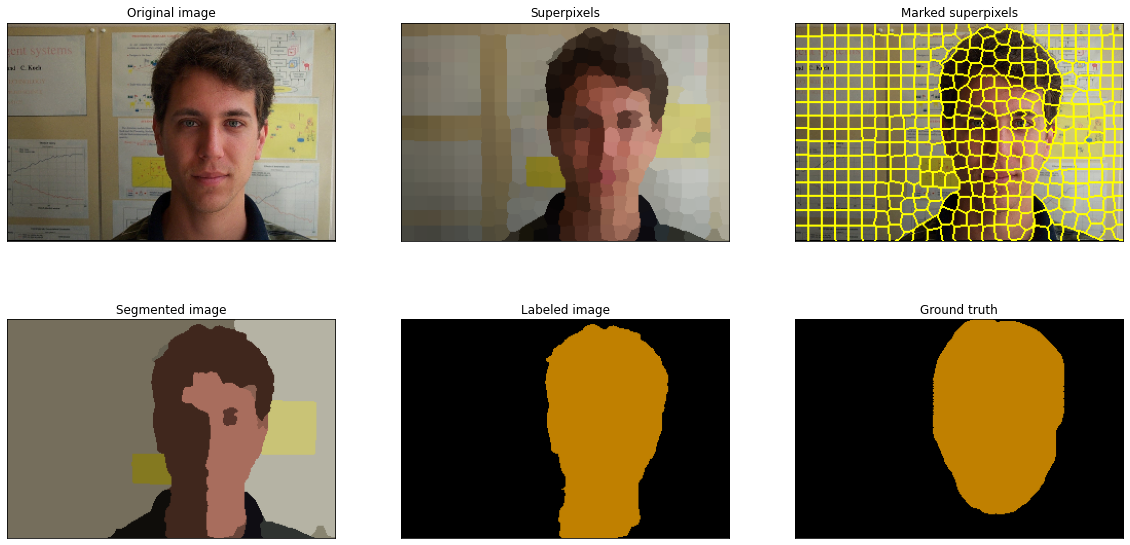

In [ ]:
img = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/6_4_s.bmp")
trg = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/6_4_s_GT.bmp")

plot_segmented_images(img, trg, 400, 30, 1)

### Example of an image of class 8

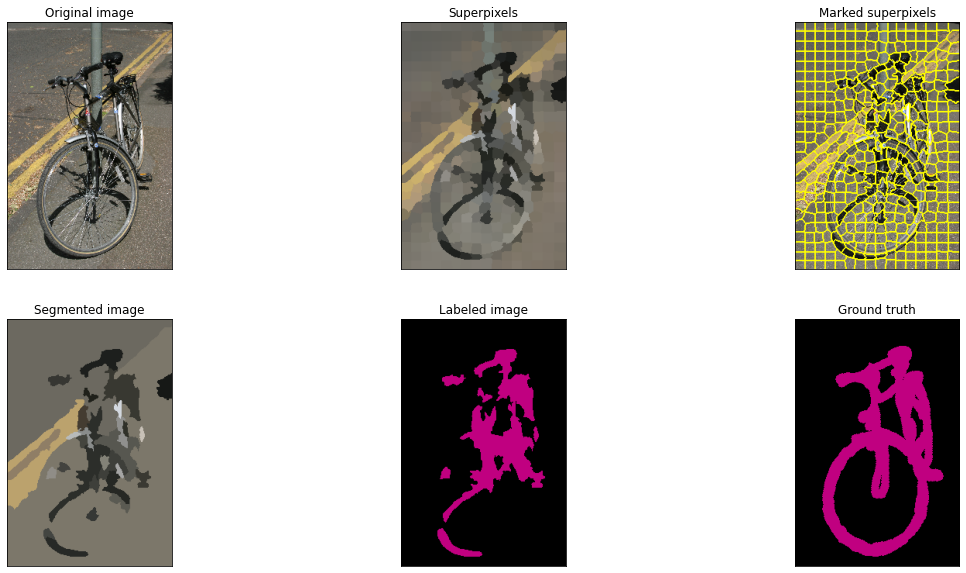

In [ ]:
img = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/8_12_s.bmp")
trg = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/8_12_s_GT.bmp")

plot_segmented_images(img, trg, 400, 30, 1)

## Printing the top 20 images with respect to pixel accuacy

In [ ]:
results_df.sort_values(by=["pixel_acc"], ascending=False).head(20)

,image_class,image_name,pixel_acc,jaccard_sim
21,1,1_2_s.bmp,1.000000,1.000000
27,1,1_7_s.bmp,1.000000,1.000000
23,1,1_3_s.bmp,1.000000,1.000000
24,1,1_4_s.bmp,1.000000,1.000000
25,1,1_5_s.bmp,1.000000,1.000000
10,1,1_1_s.bmp,1.000000,1.000000
26,1,1_6_s.bmp,1.000000,1.000000
156,6,6_16_s.bmp,0.967386,0.937307
161,6,6_20_s.bmp,0.964745,0.932405
136,5,5_25_s.bmp,0.962412,0.929431


## Printing the top 20 images with respect to Jaccard similarity

In [ ]:
results_df.sort_values(by=["jaccard_sim"], ascending=False).head(20)

,image_class,image_name,pixel_acc,jaccard_sim
26,1,1_6_s.bmp,1.000000,1.000000
10,1,1_1_s.bmp,1.000000,1.000000
23,1,1_3_s.bmp,1.000000,1.000000
21,1,1_2_s.bmp,1.000000,1.000000
27,1,1_7_s.bmp,1.000000,1.000000
25,1,1_5_s.bmp,1.000000,1.000000
24,1,1_4_s.bmp,1.000000,1.000000
156,6,6_16_s.bmp,0.967386,0.937307
161,6,6_20_s.bmp,0.964745,0.932405
136,5,5_25_s.bmp,0.962412,0.929431


 ## Showing the process for the best two images

 There are seven images that received the prefect score for both metrics, this is because those images contains only one segment that covers the whole image. Therefore I show the best two images exculding those that got the prefect score.

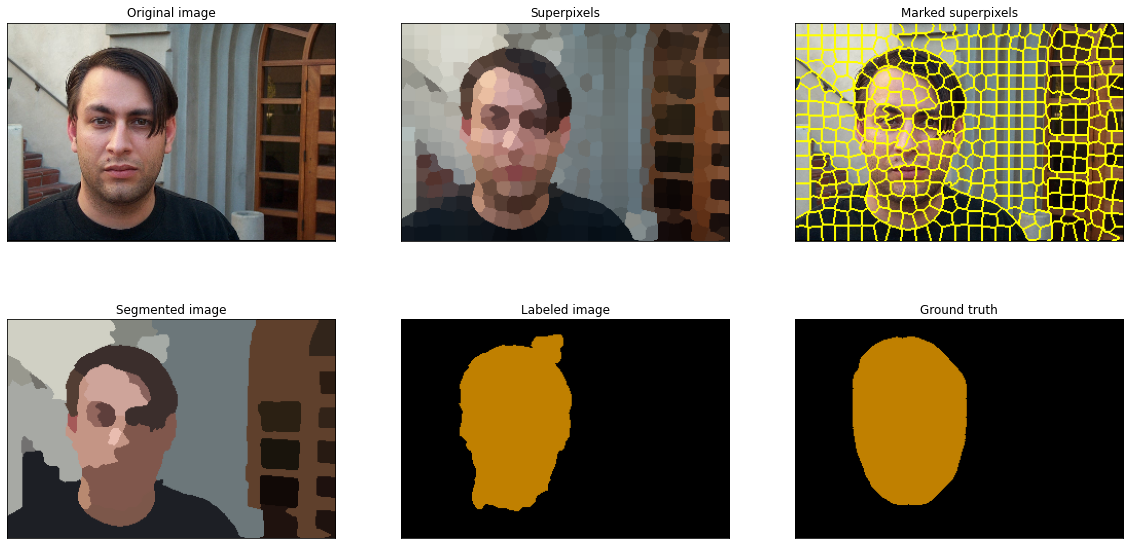

In [ ]:
img = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/6_20_s.bmp")
trg = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/6_20_s_GT.bmp")
plot_segmented_images(img, trg, n_segments=400, compactness=30, sigma=1)

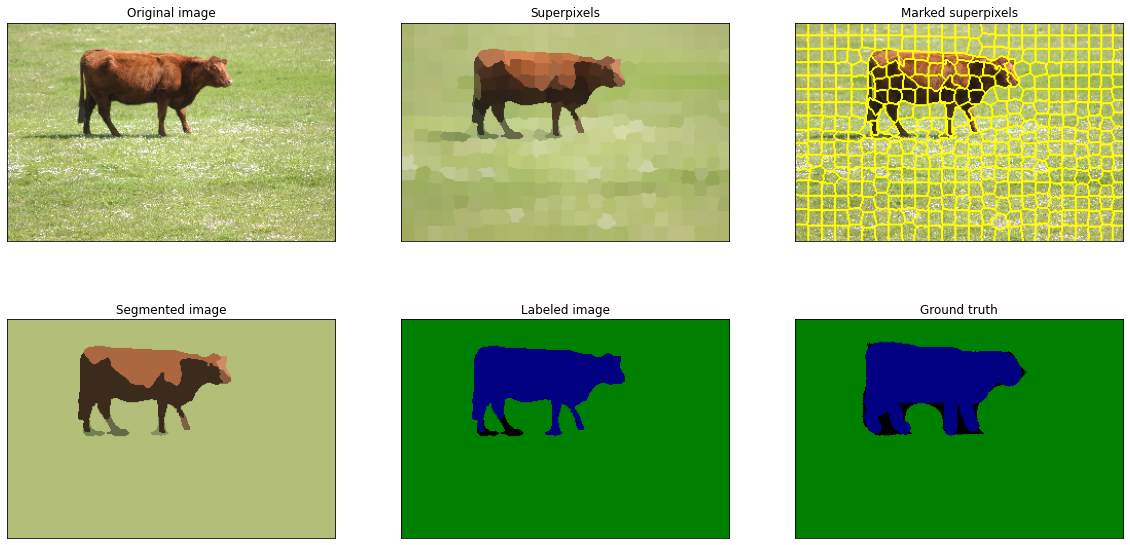

In [ ]:
img = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/5_25_s.bmp")
trg = skimage.io.imread("MSRC_ObjCategImageDatabase_v1/5_25_s_GT.bmp")
plot_segmented_images(img, trg, n_segments=400, compactness=30, sigma=1)

## Comments
The evaluation of the results is a bit artificial, since in order to compare the segmentation produced by NCut with the ground truth images, I assigned the lables to the NCut's segments using the ground truth segmentation as reference.

It can be seen in the examples showed in the notebook that NCut tends to produce many more segments than those which are effectively in the ground truth. For example in the face image (6_20_s.bmp) we can see that in the ground truth there are only two segment, one for the face and another for the background, while the segments produced by the NCut distringuishes also the different parts of the face and the elements in the background. 

In some cases the segmentation of the ground truth is a bit rough, for example in the image that I used at the beginning to explain the process (1_10_s.bmp), we can see that the segments associated to the cows are quite imprecise.

For the hyperparameters selection of the SLIC algorithms I justed tested manually some values, a better selection of the parameters could have been performed.